# Style transfer Methods, A review

### A Neural Algorithm of Artistic Style
Source: https://harishnarayanan.org/writing/artistic-style-transfer/

Using VGG16 (or 19) and a gramm matrix to solve an optimization problem

In [1]:
# Imports
import tensorflow as tf
import numpy as np
from PIL import Image

C:\Users\Acer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


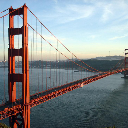

In [15]:
image_size = 512
images_path = "C:/Users/Acer/Documents/GitHub/style_transfer_2018"
# Load a content image
content_image = Image.open(images_path+"/content_images/05.jpg").resize((image_size, image_size))
style_image = Image.open(images_path+"/style_images/09.jpg").resize((image_size, image_size))
content_image.resize((128,128)) # Resize just to see it at a smaller size

(512, 512, 3)


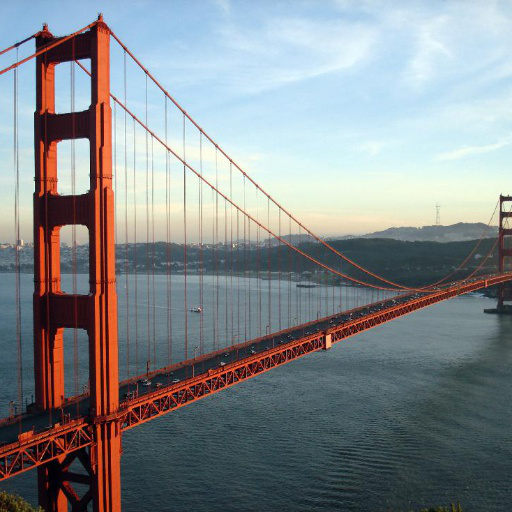

In [25]:
content_mat = np.array(content_image.convert('RGB'))
print(content_mat.shape)
#print(content_mat)
#print(content_mat.dtype)
content_image

In [27]:
# Transforming into numeric information
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

red_mean = 103.939
green_mean = 116.779
blue_mean = 123.68

content_array[:,:,:,0] -= red_mean
content_array[:,:,:,1] -= green_mean
content_array[:,:,:,2] -= blue_mean
content_array = content_array[:,:,:,::-1]
style_array[:,:,:,0] -= red_mean
style_array[:,:,:,1] -= green_mean
style_array[:,:,:,2] -= blue_mean
style_array = style_array[:,:,:,::-1]

print(content_array.shape, style_array.shape)

(1, 512, 512, 3) (1, 512, 512, 3)


In [28]:
#Defining our loss functions
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(content-combination))

def gram_matrix(x): # Hay que entenderla bien
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination): # Tambien
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (image_size ** 4))

def total_variation_loss(x):
    a = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [29]:
# Start creating the main graph
content_node = tf.constant(content_array, name = "content_image", dtype=tf.float32)
style_node = tf.constant(style_array, name = "style_image", dtype=tf.float32)
combination_image = tf.Variable(tf.random_uniform(shape=[1,image_size, image_size,3], minval = -1, maxval= 1), dtype=tf.float32)
input_ten = tf.concat([content_node, style_node, combination_image], axis = 0)

In [30]:
# Importing the VGG16 pre-trained net to use it on the content loss
vgg = tf.keras.applications.VGG16(include_top = False, weights = "imagenet", input_tensor = input_ten)

Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 11001] getaddrinfo failed

In [31]:
layers = dict([(layer.name, layer.output) for layer in vgg.layers])
layers

NameError: name 'vgg' is not defined

In [8]:
# Continue with the graph
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1

content_reference_layer = "block2_conv2"
style_reference_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

loss = tf.Variable(0, name = "total_loss", dtype=tf.float32)

content_feature_layer = layers[content_reference_layer]
loss = loss + content_weight * content_loss(content_feature_layer[0,:,:,:], content_feature_layer[2,:,:,:])

for layer in style_reference_layers:
    style_feature_layers = layers[layer]
    loss = loss + (style_loss(style_feature_layers[1,:,:,:], style_feature_layers[2,:,:,:]))*style_weight/len(style_reference_layers)

loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [9]:

# Training
learning_rate = 10
optimizer = tf.train.AdagradOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss, var_list=[combination_image])
train_step = optimizer.apply_gradients(gradients)

n_iterations = 35
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start_image = combination_image.eval()
    print(loss.eval())
    for i in range(n_iterations):
        sess.run(train_step)
        print("Error a la iteracion ", i, ": ", loss.eval())
    final_image = combination_image.eval()
    print(final_image)

7110283.5
Error a la iteracion  0 :  1645130400.0
Error a la iteracion  1 :  89424670.0
Error a la iteracion  2 :  17188716.0
Error a la iteracion  3 :  9890026.0
Error a la iteracion  4 :  7870284.5
Error a la iteracion  5 :  7196420.0
Error a la iteracion  6 :  6851845.0
Error a la iteracion  7 :  6631909.0
Error a la iteracion  8 :  6481135.5
Error a la iteracion  9 :  6373068.5
Error a la iteracion  10 :  6292947.5
Error a la iteracion  11 :  6231870.5
Error a la iteracion  12 :  6184246.5
Error a la iteracion  13 :  6146397.5
Error a la iteracion  14 :  6115805.0
Error a la iteracion  15 :  6090731.5
Error a la iteracion  16 :  6069912.0
Error a la iteracion  17 :  6052440.0
Error a la iteracion  18 :  6037627.0
Error a la iteracion  19 :  6024952.5
Error a la iteracion  20 :  6014019.5
Error a la iteracion  21 :  6004521.5
Error a la iteracion  22 :  5996210.0
Error a la iteracion  23 :  5988889.5
Error a la iteracion  24 :  5982411.5
Error a la iteracion  25 :  5976637.0
Error a

In [11]:
print(start_image-final_image)/100

[[[[-5.4726779e-01  1.0845490e+00  2.3925412e-01]
   [ 2.1955827e-01  4.1374803e-02 -5.7375360e-01]
   [-6.6019863e-02 -5.5657732e-01  5.8279401e-01]
   ...
   [ 9.4086754e-01 -8.8569337e-01 -7.8698009e-02]
   [-8.1148314e-01 -7.7979016e-01  1.0732675e+00]
   [ 7.8030705e-01 -2.3838876e-01  1.2948716e+00]]

  [[ 6.1187796e-02 -7.2158337e-02  1.4683540e-01]
   [-2.8411150e-03  7.3686862e-01  9.5400769e-01]
   [-5.1048195e-01  5.0125515e-01 -1.1612323e-01]
   ...
   [-2.0504171e-01 -2.8804427e-01 -5.8646232e-02]
   [ 8.7657481e-01  8.7991560e-01  2.0796347e-01]
   [-6.0743260e-01  3.0063254e-01  3.6011362e-01]]

  [[-2.4203537e-01  3.5715076e-01 -8.1420302e-01]
   [-6.7395377e-01  7.4450815e-01  8.1503445e-01]
   [-7.8294820e-01  1.0708330e+00 -5.4045701e-01]
   ...
   [ 1.6180096e+00 -6.1808437e-01  1.0589803e+00]
   [-2.7343005e-01  6.8074441e-01  8.3397335e-01]
   [ 6.1782509e-01  1.0143107e+00  5.4376602e-01]]

  ...

  [[-4.4678926e-02 -1.2095979e+00  2.9621696e-01]
   [-8.1535888e-

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

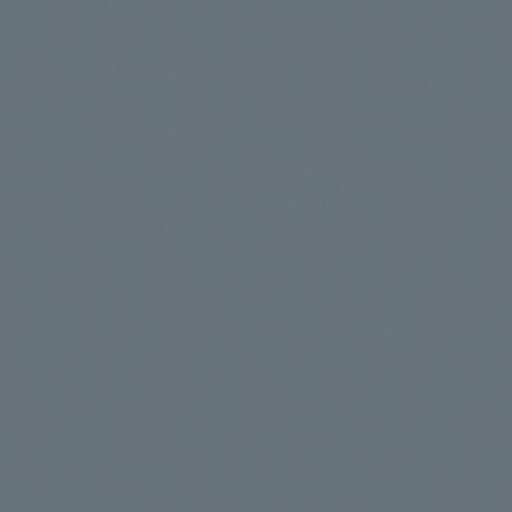

In [12]:

    
final_image = final_image.reshape((image_size, image_size, 3))
final_image = final_image[:,:,::-1]
final_image[:,:,0] += red_mean
final_image[:,:,1] += green_mean
final_image[:,:,2] += blue_mean
final_image = np.clip(final_image, 0, 255).astype("uint8")
Image.fromarray(final_image)

In [ ]:
print(final_image)